In [6]:
%load_ext autoreload
%autoreload 2
import pickle
from pathlib import Path
import subprocess

import numpy as np
import pandas as pd
import mdtraj as mdt
from pathlib import Path
import matplotlib.pyplot as plt
from parse import parse

import sys
sys.path.append("../../analysis")
from chem_shift import compute_chem_shift
from add_sidechains import add_sidechains



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
ens_path = "../../MeV_NT_ens"
cmd = rf'find {ens_path}/ensemble_200_* -regex "^.*/[0-9]+a_132\.pdb$"'
res = subprocess.run(cmd, shell=True, capture_output=True, text=True)

pdbs = [Path(pdb) for pdb in res.stdout.splitlines()]
traj = add_sidechains(pdbs)

In [ ]:
ens_cs = compute_chem_shift(traj)
ens_cs = ens_cs.droplevel("name")
ens_cs = ens_cs.reset_index("frame")

ens_avg_cs = ens_cs.groupby("resSeq")["SHIFT"].mean()

In [19]:
ens_avg_cs.to_csv("ens_avg_cs.csv")

In [20]:
def compute_cs_df(basedir, period=100):
    basedir = Path(basedir)

    xtcs = list(basedir.glob("*a_132/md_nojump.xtc"))

    pdbs = [xtc.with_suffix(".pdb") for xtc in xtcs]

    dfs = []

    for pdb, xtc in zip(pdbs, xtcs):
        conformer = parse("{:d}a_132", pdb.parent.name)[0]
        print(conformer)
        traj = mdt.load(xtc, top=pdb)

        one_every = round(period / traj.timestep)
        inds = np.arange(0, traj.time.size, one_every)
        subtraj = traj[inds]
        df = compute_chem_shift(subtraj)

        df = df.droplevel("name")
        df["conformer"] = conformer

        dfs.append(df)

    df = pd.concat(dfs)

    return df


ref_cs_df = compute_cs_df("/home/gzappavigna/traj/20241018_ff99sb-ildn_opc_multidir")
cmap_cs_df = compute_cs_df("/home/gzappavigna/traj/20241025_ff99sb-ildn_opc_cmap_multidir/")



3097
6811
4622
7057
13589
11199
14470
10440
14017
8104
15062
9802
13573
10717
1528
19517
9380
7982
9613
9510
12724
5970
7169
17425
11038
6591
4618
1120
14037
836
6125
13939
17396
11561
1313
10072
3125
5033
7576
1911
15070
3359
12973
14122
8523
3069
15809
6734
6235
5813
15996
11591
16074
11618
4070
1386
812
2504
9056
2292
12877
10498
5188
16179
724
7054
13162
16527
12088
13889
3075
8041
13609
10099
16258
14744
2938
8508
4492
11972
7719
4425
290
1220
10216
2923
10777
1340
927
12237
1532
5731
6921
873
15776
7753
3097
6811
4622
7057
13589
11199
14470
10440
14017
8104
15062
9802
13573
10717
1528
19517
9380
7982
9613
9510
12724
5970
7169
17425
11038
6591
4618
1120
14037
836
6125
13939
17396
11561
1313
10072
3125
5033
7576
1911
15070
3359
12973
14122
8523
3069
15809
6734
6235
5813
15996
11591
16074
11618
4070
1386
812
2504
9056
2292
12877
10498
5188
16179
724
7054
13162
16527
12088
13889
3075
8041
13609
10099
16258
14744
2938
8508
4492
11972
7719
4425
290
1220
10216
2923
10777
1340
927
12237


In [21]:
ref_cs_df.to_csv("ref_cs_df.csv")
cmap_cs_df.to_csv("cmap_cs_df.csv")

In [ ]:
# with (basedir / "dfs_ca_ref_10ps.pkl").open("rb") as f:
#     dfs = pickle.load(f)

In [23]:
atom_name = "(?:CA)|(?:CO)|N|(?:HN)"
pattern = rf"^(\d{{1,3}})([A-Z]?)({atom_name})-(\d{{1,3}})([A-Z]?)({atom_name})-({atom_name})$"

exp = pd.read_csv("lists_Ntail/Ntail_HNCOCA.list", sep=" ", header=None)
# exp = pd.read_csv("lists_Ntail/Ntail_HNCA.list", sep=" ", header=None)
# seq_cs = "".join(exp[0].str.extract(pattern)[1])


info = exp[0].str.extract(pattern)

exp_ca_cs = pd.Series(exp[1].to_numpy(), index=info[0].astype(int) - 525 + 132)

In [24]:
def avg_cs_rmsd(cs_df, ref):
    avg = cs_df.groupby(["resSeq", "frame"])["SHIFT"].mean()

    rmsds = []

    for i in range(0, 100+1):
        rmsds.append(np.mean((avg.xs(i, level=1) - ref).dropna() ** 2) ** 0.5)

    return rmsds

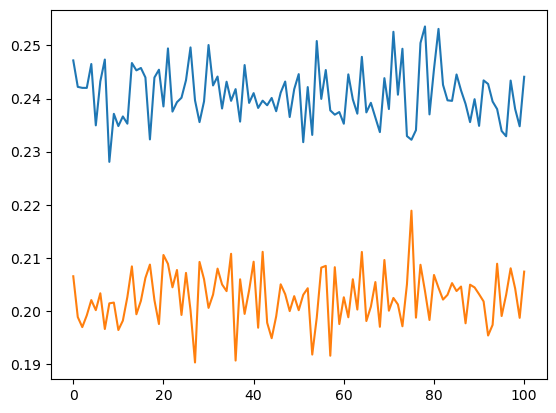

In [25]:
ref_avg = ref_cs_df.groupby(["resSeq", "frame"])["SHIFT"].mean()

plt.plot(avg_cs_rmsd(ref_cs_df, exp_ca_cs))
plt.plot(avg_cs_rmsd(cmap_cs_df, exp_ca_cs))

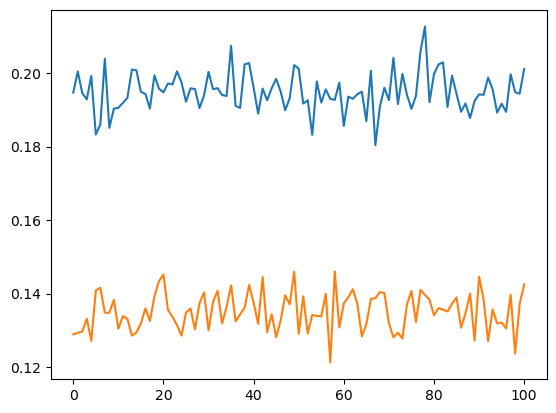

In [26]:
plt.plot(avg_cs_rmsd(ref_cs_df, ens_avg_cs))
plt.plot(avg_cs_rmsd(cmap_cs_df, ens_avg_cs))

In [33]:
ref_avg = ref_cs_df.groupby(["resSeq", "frame"])["SHIFT"].mean()
cmap_avg = cmap_cs_df.groupby(["resSeq", "frame"])["SHIFT"].mean()

In [21]:
ref_avg

resSeq  frame
1       0        55.257948
        1        55.243656
        2        55.240458
        3        55.224500
        4        55.253187
                   ...    
132     96       53.998667
        97       53.999083
        98       53.999406
        99       53.999292
        100      53.999500
Name: SHIFT, Length: 13332, dtype: float64

In [1]:
plt.figure(figsize=(20, 5))
# avg.xs(0, level=1).plot()
ref_avg.xs(100, level=1).plot()
cmap_avg.xs(100, level=1).plot()
exp_ca_cs.plot()

NameError: name 'plt' is not defined

In [171]:
np.mean((cmap_avg.xs(0, level=1) - ref_avg.xs(0, level=1)) ** 2) ** 0.5

0.14892562985879176

In [172]:
np.mean((ref_avg.xs(0, level=1) - ref_avg.xs(100, level=1)) ** 2) ** 0.5

0.08235965604724717

In [141]:
errors = []

for i in range(0, 100+1):
    errors.append(np.mean((avg.xs(i, level=1) - avg.xs(0, level=1)) ** 2) ** 0.5)

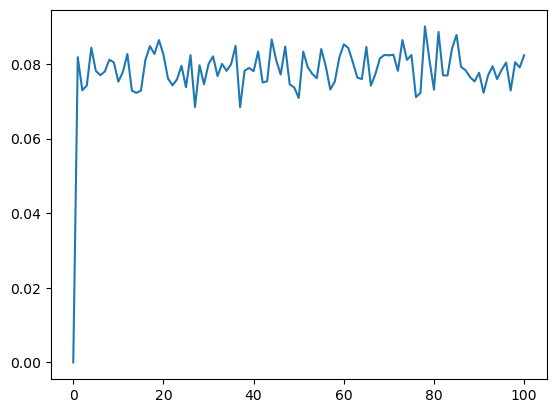

In [142]:
plt.plot(errors)

In [122]:
df = df.set_index("frame", append=True)

KeyError: "None of ['frame'] are in the columns"

In [56]:
df = df.reorder_levels(["resSeq", "frame", "conformer"])

In [58]:
df = df.sort_index()

In [30]:
df = df.sort_values(["resSeq", "frame", "conformer"])

In [40]:
df

,frame,resSeq,RC_SHIFT,SHIFT,SIGMA,SS_SHIFT,conformer
0,0,1,55.3,55.189,0.988,0.0,0
132132,0,1,55.3,55.321,0.988,0.0,1
264264,0,1,55.3,55.289,0.988,0.0,2
396396,0,1,55.3,55.285,0.988,0.0,3
528528,0,1,55.3,54.979,0.988,0.0,4
...,...,...,...,...,...,...,...
12156143,1000,132,54.0,54.006,0.868,0.0,91
12288275,1000,132,54.0,54.002,0.868,0.0,92
12420407,1000,132,54.0,53.989,0.868,0.0,93
12552539,1000,132,54.0,54.000,0.868,0.0,94


In [ ]:
avg = df.groupby("resSeq",as_index=False)["SHIFT"].rolling(100 * 96).mean()

In [92]:
avg

,resSeq,SHIFT
0,1,NaN
132132,1,NaN
264264,1,NaN
396396,1,NaN
528528,1,NaN
...,...,...
12156143,132,53.999314
12288275,132,53.999314
12420407,132,53.999314
12552539,132,53.999314


In [97]:
res=avg.groupby("resSeq")["SHIFT"].apply(lambda grp: grp.loc[::50 * 96]).dropna()

<Axes: >

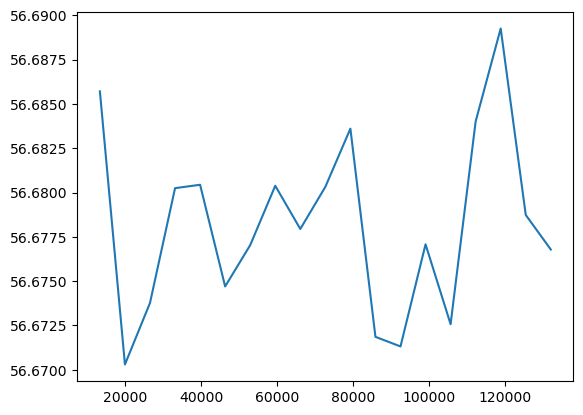

In [106]:
res[60].plot()

In [27]:
grouper = df.groupby("resSeq")[["SHIFT", "frame"]].rolling(100, on="frame").mean()

In [28]:
grouper

SHIFT  frame
resSeq                          
1      0              NaN      0
       132            NaN      1
       264            NaN      2
       396            NaN      3
       528            NaN      4
...                   ...    ...
132    12684143  53.99466    996
       12684275  53.99456    997
       12684407  53.99460    998
       12684539  53.99454    999
       12684671  53.99458   1000

[12684672 rows x 2 columns]

In [21]:
grouper = df.groupby("resSeq").rolling(100, on="frame")

In [74]:
it  = iter(grouper)

for _ in range(150):
    tmp = next(it)
tmp.mean()

RC_SHIFT     55.30000
SHIFT        55.22709
SIGMA         0.98800
SS_SHIFT      0.00000
conformer    47.66000
dtype: float64

In [22]:
grouper.mean()

frame  RC_SHIFT     SHIFT  SIGMA  SS_SHIFT  conformer
resSeq                                                                
1      0             0       NaN       NaN    NaN       NaN        NaN
       132           1       NaN       NaN    NaN       NaN        NaN
       264           2       NaN       NaN    NaN       NaN        NaN
       396           3       NaN       NaN    NaN       NaN        NaN
       528           4       NaN       NaN    NaN       NaN        NaN
...                ...       ...       ...    ...       ...        ...
132    12684143    996      54.0  53.99466  0.868       0.0       95.0
       12684275    997      54.0  53.99456  0.868       0.0       95.0
       12684407    998      54.0  53.99460  0.868       0.0       95.0
       12684539    999      54.0  53.99454  0.868       0.0       95.0
       12684671   1000      54.0  53.99458  0.868       0.0       95.0

[12684672 rows x 6 columns]

In [43]:
it = iter(res)
for _ in range(3):
    tmp = next(it)

tmp

,RC_SHIFT,SHIFT,SIGMA,SS_SHIFT
frame,,,,
0,56.048,56.301,0.932,0.299
0,56.048,55.562,1.395,-0.318
0,56.048,55.041,1.011,-1.009
0,56.048,56.440,1.426,0.373
0,56.048,55.817,1.343,-0.344
...,...,...,...,...
0,56.100,58.360,1.016,2.260
0,58.200,60.626,0.974,2.426
0,52.037,54.329,0.652,2.291


In [ ]:
# pandas rolling window=100, step=50